In [1]:
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)
web_search_results = web_search.invoke("who is the mayor of NYC?")

print(web_search_results["results"][0]["content"])

Find events, attractions, deals, and more at nyctourism.com Skip Main Navigation Menu The Official Website of the City of New York Text Size Powered by Translate SearchSearch Primary Navigation The official website of NYC Home NYC Resources NYC311 Office of the Mayor Events Connect Jobs Search Office of the Mayor | Mayor's Bio | City of New York Secondary Navigation MayorBiographyNewsOfficials Eric L. Adams 110th Mayor of New York City Mayor Eric Adams has served the people of New York City as an NYPD officer, State Senator, Brooklyn Borough President, and now as the 110th Mayor of the City of New York. Mayor Eric Adams has served the people of New York City as an NYPD officer, State Senator, Brooklyn Borough President, and now as the 110th Mayor of the City of New York. He gave voice to a diverse coalition of working families in all five boroughs and is leading the fight to bring back New York City’s economy, reduce inequality, improve public safety, and build a stronger, healthier ci

In [2]:
from langgraph.prebuilt import create_react_agent

research_agent = create_react_agent(
    model="openai:gpt-4.1-mini",
    tools=[web_search],
    prompt=(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT do any math\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="research_agent",
)

In [3]:
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [4]:
for chunk in research_agent.stream(
    {"messages": [{"role": "user", "content": "who is the mayor of NYC?"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: research_agent
Tool Calls:
  tavily_search (call_xZO8QUVPeVA92on5AqCjbUJr)
 Call ID: call_xZO8QUVPeVA92on5AqCjbUJr
  Args:
    query: mayor of New York City 2024


Update from node tools:


================================= Tool Message =================================
Name: tavily_search

{"query": "mayor of New York City 2024", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Who's next in line to be NYC mayor if Eric Adams resigns?", "url": "https://abcnews.go.com/Politics/line-nyc-mayor-eric-adams-resigns/story?id=114180650", "content": "Who is NYC Public Advocate Jumaane Williams?The former New York City councilmember would be next in line if Eric Adams resigns as New York City mayor. Questions about New York City Mayor Eric Adams' future in office have begun to swirl as he faces indictment by a federal grand jury amid calls for his res

In [5]:
def add(a: float, b: float):
    """Add two numbers."""
    return a + b


def multiply(a: float, b: float):
    """Multiply two numbers."""
    return a * b


def divide(a: float, b: float):
    """Divide two numbers."""
    return a / b


math_agent = create_react_agent(
    model="openai:gpt-4.1-mini",
    tools=[add, multiply, divide],
    prompt=(
        "You are a math agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with math-related tasks\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="math_agent",
)

In [6]:
for chunk in math_agent.stream(
    {"messages": [{"role": "user", "content": "what's (3 + 5) x 7"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  add (call_ibrvz8UTmFE3QAF1cF1agr3q)
 Call ID: call_ibrvz8UTmFE3QAF1cF1agr3q
  Args:
    a: 3
    b: 5
  multiply (call_wVHVduFKaHsUcMsyN2d6vC9I)
 Call ID: call_wVHVduFKaHsUcMsyN2d6vC9I
  Args:
    a: 8
    b: 7


Update from node tools:


================================= Tool Message =================================
Name: add

8.0


Update from node tools:


================================= Tool Message =================================
Name: multiply

56.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent

(3 + 5) x 7 = 56




In [7]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
    model=init_chat_model("openai:gpt-4.1-mini"),
    agents=[research_agent, math_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()

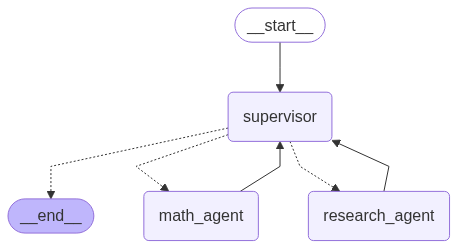

In [8]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

In [9]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "find US and New York state GDP in 2024. what % of US GDP was New York state?",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_math_agent

Successfully transferred to math_agent


Update from node math_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

The estimated GDP of the United States in 2024 is approximately $28.18 trillion. The approximate GDP of Ne